# <center>Computer Vision - TP 3 - Mathematical Morphology</center>

## Table of Content
### 0. Preliminaries
### 1. Edge Detection
     Morphological gradient
### 2. Noise & Filtering
     Salt & Pepper Noise, Median Filter
### 3. Lightning Uniformization
     Local Adaptive Image Normalization
### 4. Segmentation
     Connected Component Labeling & Watershed

# 0. Preliminaries

In [1]:
import numpy as np
import math
import cv2
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import tools

from ipywidgets import interact, fixed

def normalize_image(img):
    img = img.astype(float)
    return ( img - np.min(img)) / ( np.max(img) - np.min(img))

def normL1(imgX, imgY):
    return np.abs(imgX) + np.abs(imgY)

def normL2(imgX, imgY):
    return np.sqrt( imgX * imgX + imgY * imgY)


# 1. Edge detection

## 1.1. Sobel and Scharr

In [2]:
def sobel_grad(img, ksize):
    # Sobel gradient
    img_sobelX = cv2.Sobel( img, cv2.CV_32F, 1, 0, ksize=ksize)
    img_sobelY = cv2.Sobel( img, cv2.CV_32F, 0, 1, ksize=ksize)    
    return normalize_image( normL2( img_sobelX, img_sobelY))

def scharr_grad(img):
    # Scharr gradient
    img_scharrX = cv2.Scharr( img, cv2.CV_32F, 1, 0)
    img_scharrY = cv2.Scharr( img, cv2.CV_32F, 0, 1)
        
    return normalize_image( normL2( img_scharrX, img_scharrY))

## 1.2. Laplacian and Difference of Gaussian (LoG/DoG)

In [3]:
def LoG(img, ksize):
    # Laplacian of Gaussian
    img_float = img.astype( float)
    sigma = 0.3 * ( ( ksize - 1) * 0.5 - 1) + 0.8     # ksize = 5 --> sigma = 1.1
    img_gauss_blur = cv2.GaussianBlur( img_float, (0,0), sigma)

    #kfact = 1.0 / np.power( 2.0, 2 * ( ksize - 2) - 6)
    img_Gauss_X2 = cv2.Sobel( img_gauss_blur, cv2.CV_64F, 2, 0, ksize=ksize-2)
    img_Gauss_Y2 = cv2.Sobel( img_gauss_blur, cv2.CV_64F, 0, 2, ksize=ksize-2)
    
    return normalize_image( np.abs( img_Gauss_X2 + img_Gauss_Y2))

def DoG(img, ksize):
    # Difference of Gaussian
    img_float = img.astype( float)
    sigma1 = 0.3 * ( ( ksize - 1) * 0.5 - 1) + 0.8     # ksize = 5 --> sigma = 1.1
    img_gauss_blur_1 = cv2.GaussianBlur( img_float, (0, 0), sigma1, sigma1)

    sigma2 = sigma1 * 1.6
    img_gauss_blur_2 = cv2.GaussianBlur( img_float, ( 0, 0), sigma2, sigma2)

    return normalize_image( np.abs( 1.6 * ( img_gauss_blur_2 - img_gauss_blur_1) / ( sigma1 * sigma1)))


## 1.3. Morphological gradient (Beucher)

In [4]:
def beucher_grad(img, ksize):
    # Morphological Beucher gradient
    kernel = np.ones( ( ksize, ksize), np.uint8)
    img_dlt = cv2.dilate( img, kernel)
    img_ers = cv2.erode( img, kernel)
    img_beucher = img_dlt - img_ers
    #img_beucher = cv2.morphologyEx( img, cv2.MORPH_GRADIENT, kernel)
    return normalize_image( img_beucher)


## 1.4. Comparison

In [8]:
img = cv2.imread( 'Images/Pattern_inspection2.png', cv2.IMREAD_GRAYSCALE)

def update(ksize=3):
    img_sobel_norm = sobel_grad(img, ksize)
    img_LoG_norm = LoG(img, ksize)
    img_DoG_norm = DoG(img, ksize)
    img_beucher_norm = beucher_grad(img, ksize)
    
    tools.multiPlot( 2, 2, ( img, img_beucher_norm, img_sobel_norm, img_LoG_norm),
                    ( 'Original image', 'Morphological Beucher gradient', 'Sobel', 'LoG'),
                    cmap_tuple=( cm.gray, cm.gray, cm.gray, cm.gray))

interact(update, ksize = (3, 15, 2))


interactive(children=(IntSlider(value=3, description='ksize', max=15, min=3, step=2), Output()), _dom_classes=…

<function __main__.update(ksize=3)>

# 2. Noise and filtering

## 2.1. Gaussian noise

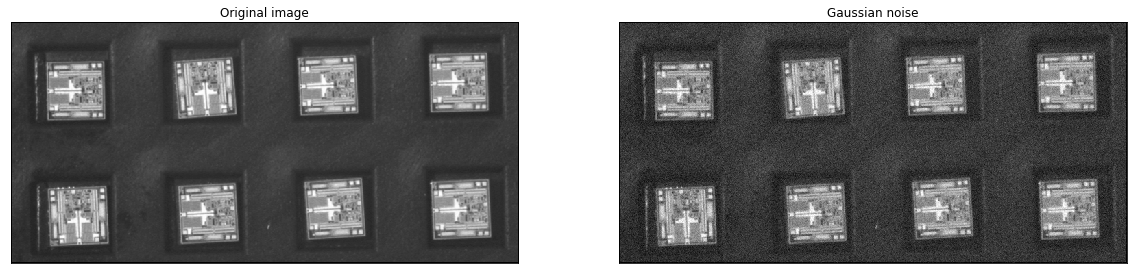

In [9]:
pat = cv2.imread( 'Images/Pattern_inspection2.png', cv2.IMREAD_GRAYSCALE)

gauss_noise = np.empty_like( pat, dtype=float)
mean = 0.0
sigma = 10.0
cv2.randn( gauss_noise, mean, sigma)

pat_noisy = tools.saturate_cast_uint8( pat + gauss_noise)

tools.multiPlot( 1, 2, ( pat, pat_noisy),
                ( 'Original image', 'Gaussian noise'),
                cmap_tuple=( cm.gray, cm.gray))

## 2.2. Uniform, Gaussian & bilateral filtering

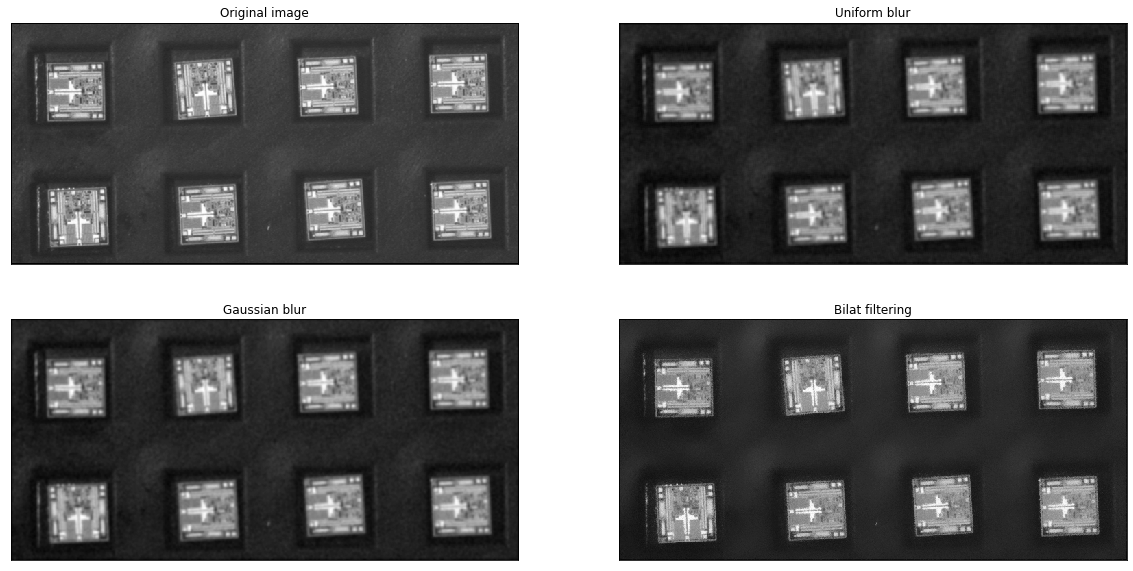

In [10]:
pat_noisy_unif_blur = cv2.blur( pat_noisy, ( 5, 5))
pat_noisy_gauss_blur = cv2.GaussianBlur( pat_noisy, ( 7, 7), 0)
pat_noisy_bilat = cv2.bilateralFilter( pat_noisy, -1, 25, 11)

tools.multiPlot( 2, 2, ( pat, pat_noisy_unif_blur, pat_noisy_gauss_blur, pat_noisy_bilat),
                 ( 'Original image', 'Uniform blur', 'Gaussian blur', 'Bilat filtering'),
                 cmap_tuple=( cm.gray, cm.gray, cm.gray, cm.gray))

## 2.2. Salt & pepper noise

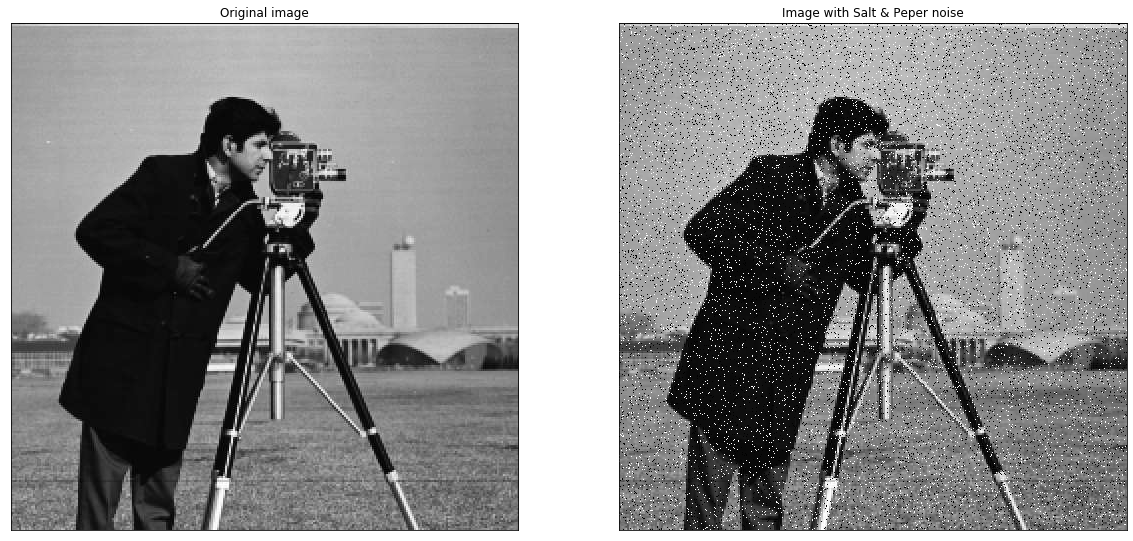

In [11]:
cam = cv2.imread('Images/cameraman.jpg', cv2.IMREAD_GRAYSCALE)

saltpepper_noise = np.zeros_like( cam)
cv2.randu( saltpepper_noise, 0, 255)

cam_noisy = np.where( saltpepper_noise < 10, 0, np.where( saltpepper_noise > 245, 255, cam))

tools.multiPlot( 1, 2, ( cam, cam_noisy),
                ( 'Original image', 'Image with Salt & Peper noise'),
                cmap_tuple=( cm.gray, cm.gray))

### Uniform/Gaussian/Bilateral filter for Salt & Pepper noise

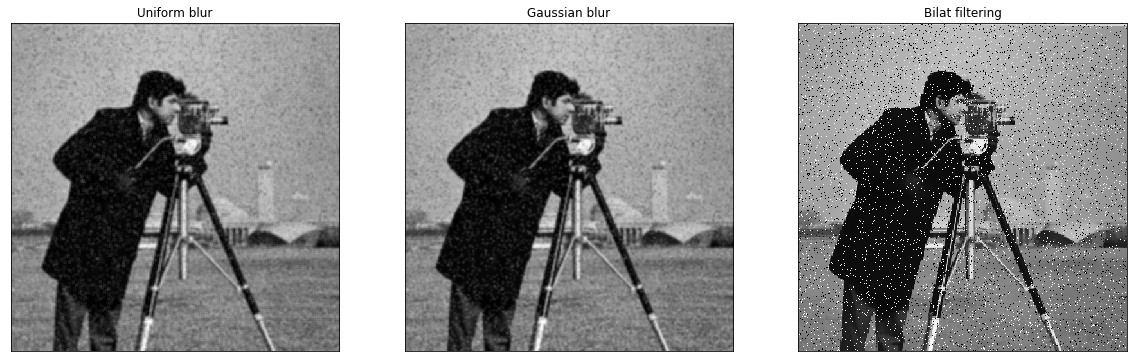

In [12]:
cam_noisy_unif_blur = cv2.blur( cam_noisy, ( 5, 5))
cam_noisy_gauss_blur = cv2.GaussianBlur( cam_noisy, ( 7, 7), 0)
cam_noisy_bilat = cv2.bilateralFilter( cam_noisy, -1, 25, 11)

tools.multiPlot( 1, 3, ( cam_noisy_unif_blur, cam_noisy_gauss_blur, cam_noisy_bilat),
                 ( 'Uniform blur', 'Gaussian blur', 'Bilat filtering'),
                 cmap_tuple=(  cm.gray, cm.gray, cm.gray))

## 2.3. Median filtering

In [13]:
cam = cv2.imread('Images/cameraman.jpg', cv2.IMREAD_GRAYSCALE)

def update(noise_level=10, median_kernel=5):
    saltpepper_noise = np.zeros_like( cam)
    cv2.randu( saltpepper_noise, 0, 255)

    cam_noisy = np.where( saltpepper_noise < noise_level, 0,
                         np.where( saltpepper_noise > 255 - noise_level, 255, cam))

    cam_noisy_med_blur = cv2.medianBlur( cam_noisy, median_kernel)

    tools.multiPlot( 1, 3, ( cam, cam_noisy, cam_noisy_med_blur),
                     ( 'Original image', 'Noisy image', 'Median blur'),
                     cmap_tuple=( cm.gray, cm.gray, cm.gray))

interact(update, noise_level=(5,100,5), median_kernel = (3, 25, 2))


interactive(children=(IntSlider(value=10, description='noise_level', min=5, step=5), IntSlider(value=5, descri…

<function __main__.update(noise_level=10, median_kernel=5)>

# 3. Lightning uniformization

## 3.1. Non uniform lightning

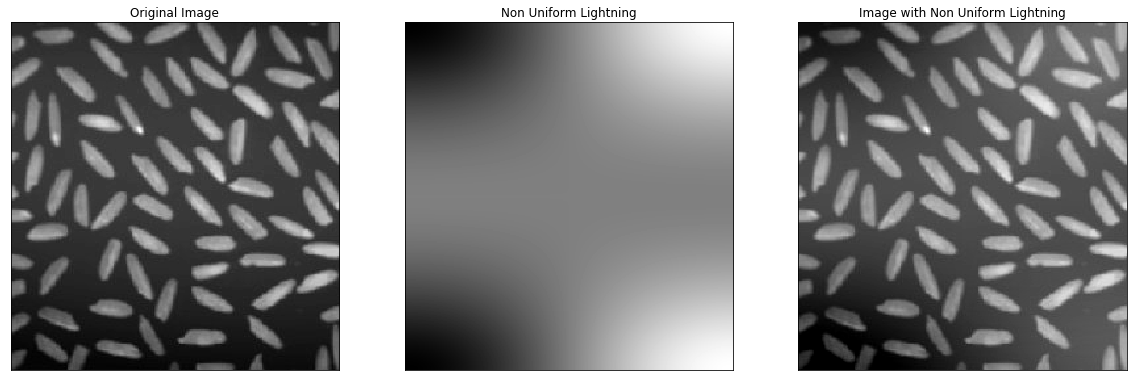

In [14]:
def non_uniform_lightning_like(img, weight):
    width = img.shape[1]
    height = img.shape[0]
    
    steps_y = np.arange( start=0.0, stop=1.0, step=1.0/height)
    light_gradient_y = np.cos( ( 2.0 * ( steps_y * steps_y - steps_y) + 1.0)* np.pi)[:,np.newaxis]

    steps_x = np.arange( start=0.0, stop=1.0, step=1.0/width)
    light_gradient_x = np.cos( steps_x * np.pi)[np.newaxis,:]

    return ( weight * light_gradient_y * light_gradient_x)

# Load a grayscale image as grayscale
img = cv2.imread( 'Images/rice.jpg', cv2.IMREAD_GRAYSCALE)

# Add non uniform lightning
non_uniform_lightning = non_uniform_lightning_like( img, 50)
img_nu = tools.saturate_cast_uint8( img + non_uniform_lightning)

# plot the images
tools.multiPlot( 1, 3, ( img, non_uniform_lightning, img_nu),
                      ( 'Original Image', 'Non Uniform Lightning', 'Image with Non Uniform Lightning'),
                       cmap_tuple=( cm.gray, cm.gray, cm.gray))

## 3.2. Global Otsu's algorithm

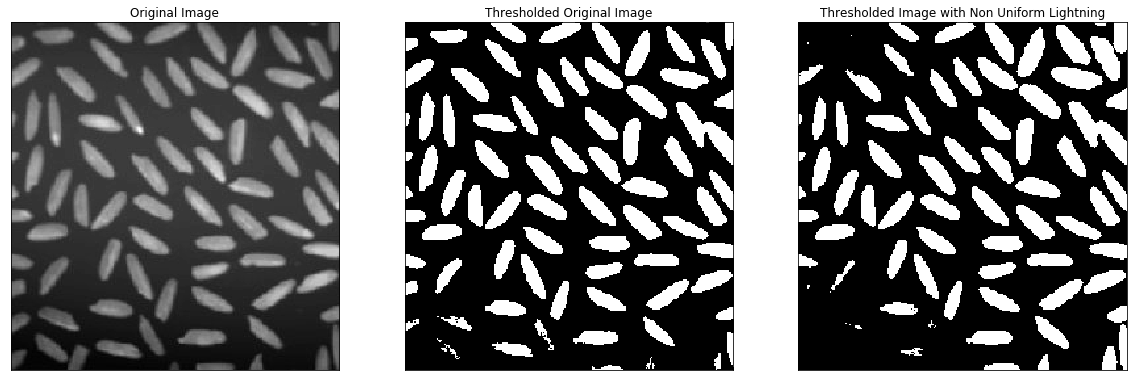

In [15]:
# Otsu's thresholding
ret1, img_th = cv2.threshold( img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
ret2, img_nu_th = cv2.threshold( img_nu, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

tools.multiPlot( 1, 3, ( img, img_th, img_nu_th),
                       ( 'Original Image', 'Thresholded Original Image', 'Thresholded Image with Non Uniform Lightning'),
                        cmap_tuple=( cm.gray, cm.gray, cm.gray))


## 3.3. Local reference for the background and the foreground

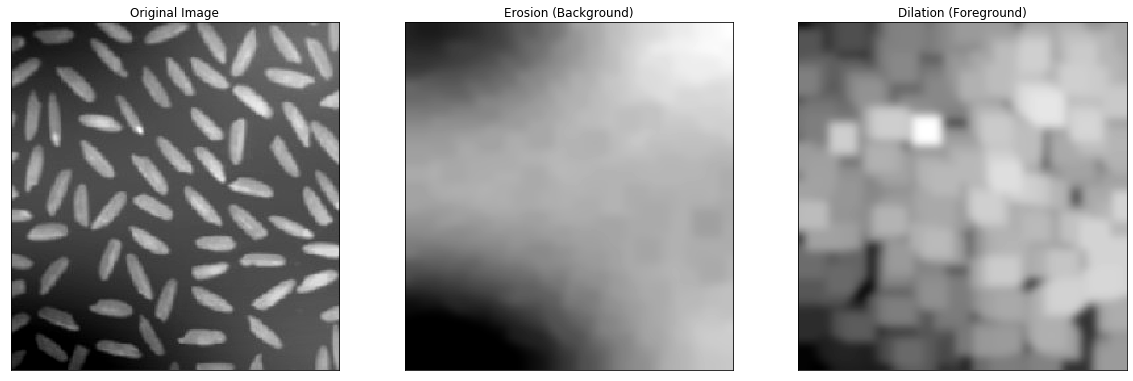

In [16]:
# Compute the local background and foreground for the image
ksize = 20
kernel = np.ones( ( ksize, ksize), np.uint8)

img_nu_erd = cv2.GaussianBlur( cv2.erode( img_nu, kernel, iterations = 1).astype( float), (ksize-1, ksize-1), 0)
img_nu_dlt = cv2.GaussianBlur( cv2.dilate( img_nu, kernel, iterations = 1).astype( float), (ksize-1, ksize-1), 0)

# plot the images
tools.multiPlot( 1, 3, ( img_nu, img_nu_erd, img_nu_dlt),
                      ( 'Original Image', 'Erosion (Background)', 'Dilation (Foreground)'),
                       cmap_tuple=( cm.gray, cm.gray, cm.gray))

## 3.4. Local adaptation of the image gain and offset

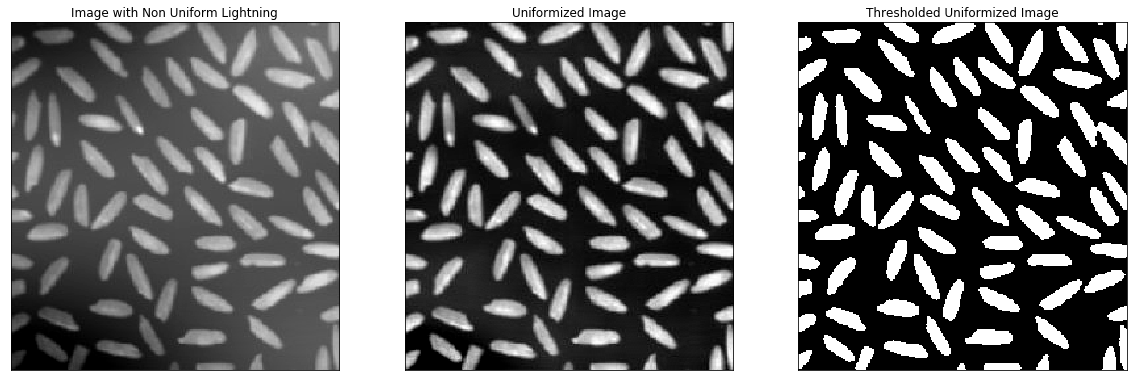

In [17]:
def local_normalize_image(img, ksize=30):
    # Compute the local background and foreground for the image
    kernel = np.ones( ( ksize, ksize), np.uint8)
    
    if ksize % 2 == 0:
        ksize -= 1

    img_erd = cv2.GaussianBlur( cv2.erode( img, kernel, iterations = 1).astype( float), (ksize, ksize), 0)
    img_dlt = cv2.GaussianBlur( cv2.dilate( img, kernel, iterations = 1).astype( float), (ksize, ksize), 0)
    
    return tools.saturate_cast_uint8( ( img - img_erd) * 255.0 / ( img_dlt - img_erd + 1))

# Lightning uniformization - Offset and gain correction
img_nu_norm = local_normalize_image(img_nu, ksize=30)

# Otsu's thresholding
ret, img_nu_norm_th = cv2.threshold( img_nu_norm, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# plot all the images and their histograms
tools.multiPlot( 1, 3, ( img_nu, img_nu_norm, img_nu_norm_th),
                      ( 'Image with Non Uniform Lightning', 'Uniformized Image', 'Thresholded Uniformized Image'),
                       cmap_tuple=( cm.gray, cm.gray, cm.gray))

# 4. Segmentation

## 4.1. Image thresholding & Connected components labelling

Number of labels = 57


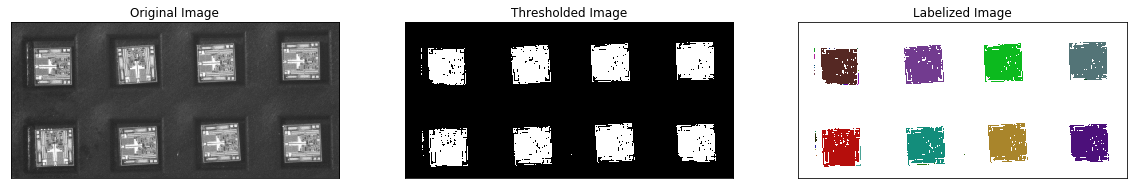

In [18]:
# Load a grayscale image as grayscale 
img = cv2.imread( 'Images/Pattern_inspection2.png', cv2.IMREAD_GRAYSCALE)

# Otsu's thresholding
re1,img_th = cv2.threshold( img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# You need to choose 4 or 8 for connectivity type
connectivity = 4
# Perform the operation
conn_comp = cv2.connectedComponentsWithStats( img_th, connectivity, cv2.CV_32S)

# Get the results
num_labels = conn_comp[0]      # The first cell is the number of labels
img_labels = conn_comp[1]      # The second cell is the label matrix

print('Number of labels = %d' % num_labels)

labelColors = tools.getRandomColorMap( num_labels)

# plot all the images and their histograms
tools.multiPlot( 1, 3, ( img, img_th, img_labels),
                        ( 'Original Image', 'Thresholded Image', 'Labelized Image'),
                        cmap_tuple=( cm.gray, cm.gray, labelColors))


### With Preprocessing

Number of labels = 9


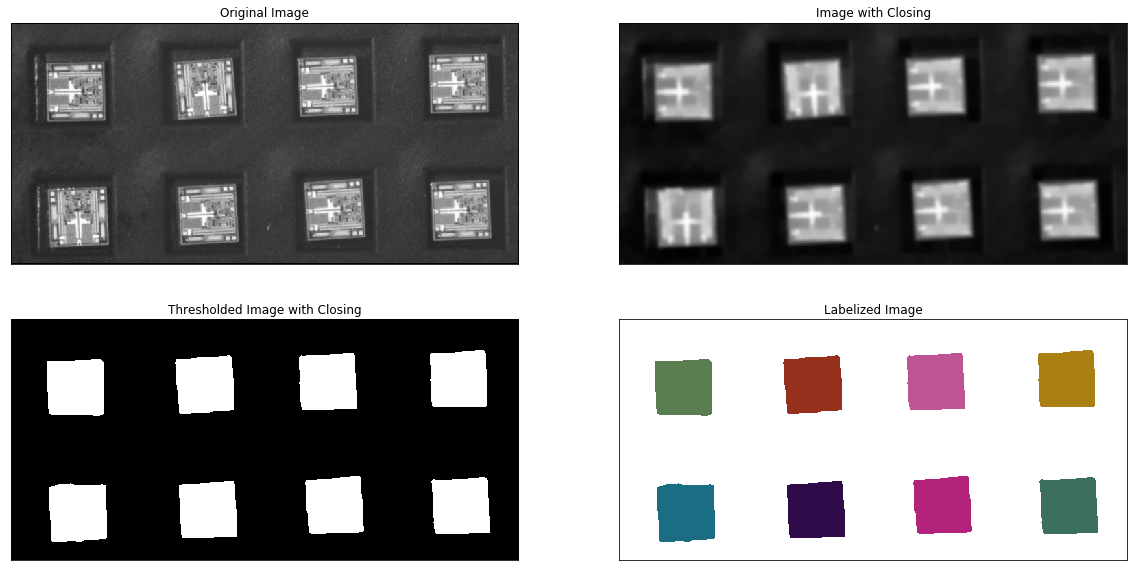

In [19]:
def connect_comp_label_with_closing(img, ksize):
    # Preprocess image (closing)
    kernel = np.ones( ( ksize, ksize), np.uint8)
    
    img_closing = cv2.GaussianBlur( cv2.morphologyEx( img, cv2.MORPH_CLOSE, kernel).astype( float), (ksize, ksize), 0)
    img_closing = tools.saturate_cast_uint8( img_closing)

    # Otsu's thresholding
    ret, img_closing_th = cv2.threshold( img_closing, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # You need to choose 4 or 8 for connectivity type
    connectivity = 4
    
    # Perform the operation
    return cv2.connectedComponentsWithStats( img_closing_th, connectivity, cv2.CV_32S), img_closing, img_closing_th

# Load a grayscale image as grayscale 
img = cv2.imread( 'Images/Pattern_inspection2.png', cv2.IMREAD_GRAYSCALE)

# Connected components labeling
conn_comp, img_closing, img_closing_th = connect_comp_label_with_closing( img, 13)

# Get the results
num_labels = conn_comp[0]      # The first cell is the number of labels
img_labels = conn_comp[1]      # The second cell is the label matrix

print('Number of labels = %d' % num_labels)

labelColors = tools.getRandomColorMap( num_labels)

# plot all the images and their histograms
tools.multiPlot( 2, 2, ( img, img_closing, img_closing_th, img_labels),
                        ( 'Original Image', 'Image with Closing', 'Thresholded Image with Closing', 'Labelized Image'),
                        cmap_tuple=( cm.gray, cm.gray, cm.gray, labelColors))



### Compute blob features

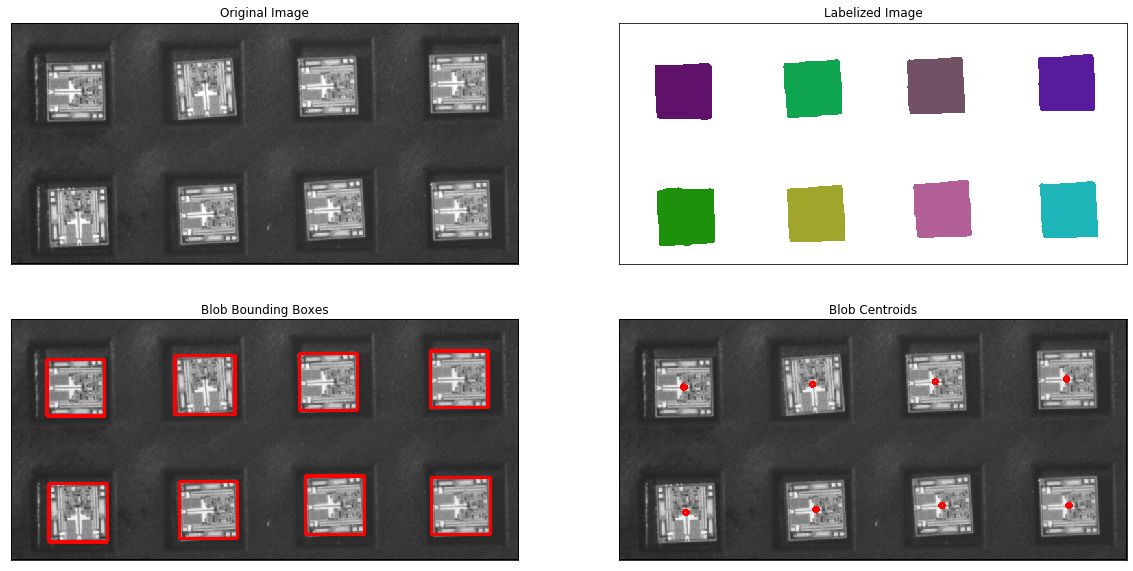

In [21]:
def draw_blob_bounding_boxes(img, conn_comp):
    num_labels = conn_comp[0]  # The first cell is the number of labels
    stats = conn_comp[2]       # The third cell is the stat matrix
    
    # Draw blob bounding boxes
    img_bb = cv2.cvtColor( img, cv2.COLOR_GRAY2RGB)
    for label in range( 1, num_labels):
        topleft = tuple( stats[label,:2])
        bottomright = tuple( stats[label,:2] + stats[label, 2:4])
        cv2.rectangle( img_bb, topleft, bottomright, (255,0,0), 3)
    
    return img_bb


def draw_blob_centroids(img, conn_comp):
    num_labels = conn_comp[0]  # The first cell is the number of labels
    centroids = conn_comp[3]   # The fourth cell is the centroid matrix
    
    # Draw blob centroids
    img_ctr = cv2.cvtColor( img, cv2.COLOR_GRAY2RGB)
    for label in range( 1, num_labels):
        centroid = tuple( centroids[label,:].astype(int))
        cv2.circle( img_ctr, centroid, 3, (255,0,0), thickness=3)
    
    return img_ctr
    

# Load a grayscale image as grayscale 
img = cv2.imread( 'Images/Pattern_inspection2.png', cv2.IMREAD_GRAYSCALE)

# Connected components labeling
conn_comp, img_closing, img_closing_th = connect_comp_label_with_closing( img, 13)

# Get the results
num_labels = conn_comp[0]  # The first cell is the number of labels
img_labels = conn_comp[1]  # The second cell is the label matrix

labelColors = tools.getRandomColorMap( num_labels)

# Draw blob bounding boxes
img_bb = draw_blob_bounding_boxes( img, conn_comp)

# Draw blob centroids
img_ctr = draw_blob_centroids( img, conn_comp)

# plot all the images and their histograms
tools.multiPlot( 2, 2, ( img, img_labels, img_bb, img_ctr),
                       ( 'Original Image', 'Labelized Image', 'Blob Bounding Boxes', 'Blob Centroids'),
                        cmap_tuple=( cm.gray, labelColors, None, None))

### Another example

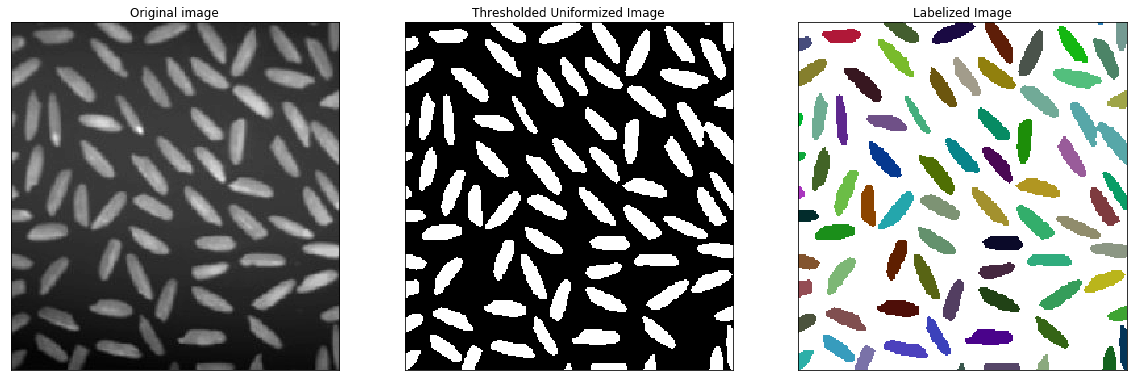

In [22]:
def connect_comp_label_with_uniformization(img, ksize):
    # Preprocess image (uniformization)
    img_norm = local_normalize_image( img, ksize)

    # Otsu's thresholding
    ret, img_norm_th = cv2.threshold( img_norm, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # You need to choose 4 or 8 for connectivity type
    connectivity = 4
    
    # Perform the operation
    return cv2.connectedComponentsWithStats( img_norm_th, connectivity, cv2.CV_32S), img_norm, img_norm_th

# Load a grayscale image as grayscale 
rice = cv2.imread( 'Images/rice.jpg', cv2.IMREAD_GRAYSCALE)

# Connected components labeling
rice_conn_comp, rice_norm, rice_norm_th = connect_comp_label_with_uniformization( rice, 30)
    
# Get the results
num_rice_labels = rice_conn_comp[0]      # The first cell is the number of labels
rice_img_labels = rice_conn_comp[1]      # The second cell is the label matrix

labelColors = tools.getRandomColorMap( num_rice_labels)

# plot all the images and their histograms
tools.multiPlot( 1, 3, ( rice, rice_norm_th, rice_img_labels),
                        ( 'Original image', 'Thresholded Uniformized Image', 'Labelized Image'),
                        cmap_tuple=( cm.gray, cm.gray, labelColors))


### Approximate ellipse parameters

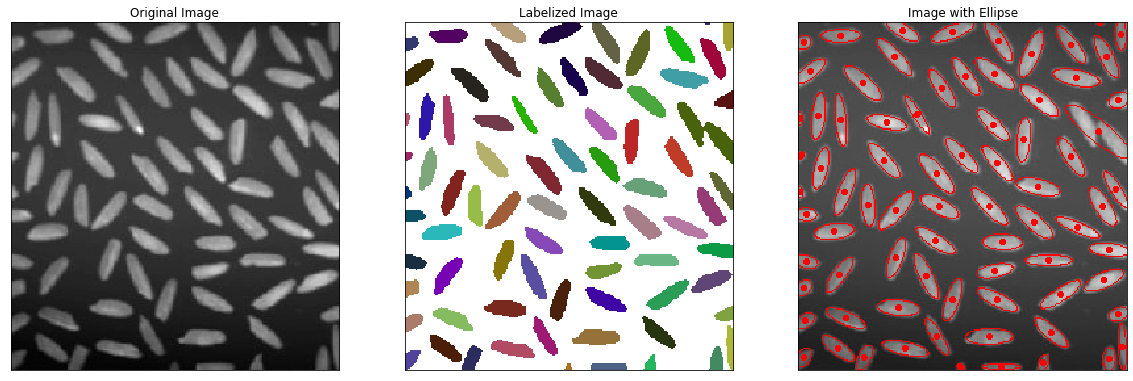

In [23]:
def draw_blob_ellipse_approximation_from_moments(img, conn_comp):
    num_labels = conn_comp[0]   # The first cell is the number of labels
    img_labels = conn_comp[1]   # The second cell is the label matrix
    stats = conn_comp[2]        # The third cell is the stat matrix
    centroids = conn_comp[3].astype(int)    # The fourth cell is the centroid matrix
    
    width = img.shape[1]
    height = img.shape[0]
    
    x_range = np.arange(width)
    y_range = np.arange(height)
    x_array, y_array = np.meshgrid(x_range, y_range)

    # Draw ellipses
    img_elps = cv2.cvtColor( img, cv2.COLOR_GRAY2RGB)
    for label in range( 1, num_labels):
        xc = centroids[label,0]
        yc = centroids[label,1]
        xl = x_array[img_labels == label] - xc
        yl = y_array[img_labels == label] - yc
        n = np.sum(img_labels == label)
        Mxx = np.sum(np.square(xl)) / n
        Myy = np.sum(np.square(yl)) / n
        Mxy = np.sum(xl * yl) / n
        discr = math.sqrt(4.0 * Mxy * Mxy + (Mxx - Myy) ** 2)
        a = int( math.sqrt( 2.0 * ( Mxx + Myy + discr)))
        b = int( math.sqrt( 2.0 * ( Mxx + Myy - discr)))
        theta = int( 0.5 * math.atan2( 2.0 * Mxy, Mxx - Myy) * 180.0 / np.pi)
        #print( 'Label %d: xc = %d, yc = %d, a = %d, b = %d, theta = %d' % ( label, xc, yc, a, b, theta))
        
        cv2.ellipse( img_elps, (xc, yc), (a, b), theta, 0, 360, (255,0,0), thickness=1)
        cv2.circle( img_elps, (xc, yc), 1, (255,0,0), thickness=2)

    return img_elps
    
# Load a grayscale image as grayscale 
rice = cv2.imread( 'Images/rice.jpg', cv2.IMREAD_GRAYSCALE)

# Connected components labeling
rice_conn_comp, rice_norm, rice_norm_th = connect_comp_label_with_uniformization( rice, 30)
    
# Get the results
num_rice_labels = rice_conn_comp[0]    # The first cell is the number of labels
rice_img_labels = rice_conn_comp[1]    # The second cell is the label matrix

labelColors = tools.getRandomColorMap( num_rice_labels)

# Draw the ellipses
rice_img_elps = draw_blob_ellipse_approximation_from_moments( rice, rice_conn_comp)

# plot all the images and their histograms
tools.multiPlot( 1, 3, ( rice, rice_img_labels, rice_img_elps),
                        ( 'Original Image', 'Labelized Image', 'Image with Ellipse'),
                        cmap_tuple=( cm.gray, labelColors, None))


## 4.2. Watershed

### Binarize the image

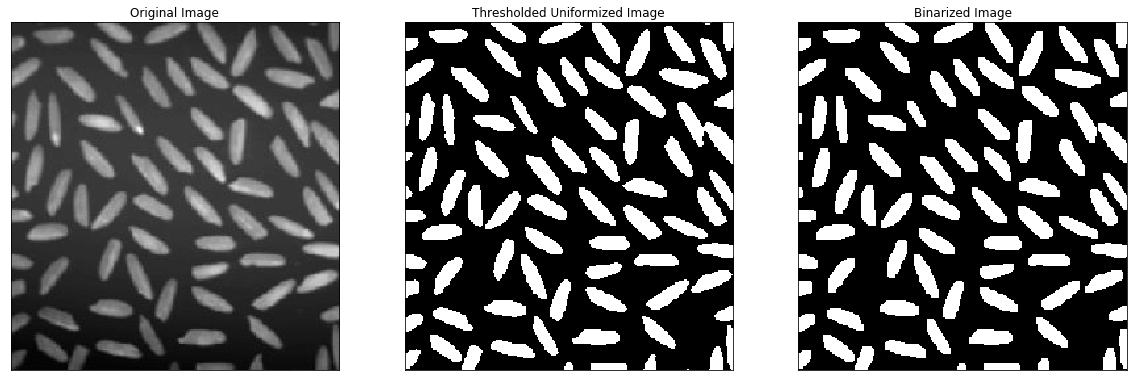

In [24]:
# Load a grayscale image as grayscale
img = cv2.imread( 'Images/rice.jpg', cv2.IMREAD_GRAYSCALE)

# Preprocess image (uniformization)
img_norm = local_normalize_image( img, 20)

# Otsu's thresholding
ret, img_norm_th = cv2.threshold( img_norm, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# noise removal
kernel = np.ones((3,3),np.uint8)
img_bin = cv2.morphologyEx( img_norm_th, cv2.MORPH_OPEN,kernel, iterations = 2)

# plot all the images and their histograms
tools.multiPlot( 1, 3, ( img, img_norm_th, img_bin),
                       ( 'Original Image', 'Thresholded Uniformized Image', 'Binarized Image'),
                        cmap_tuple=( cm.gray, cm.gray, cm.gray))


### Find sure background

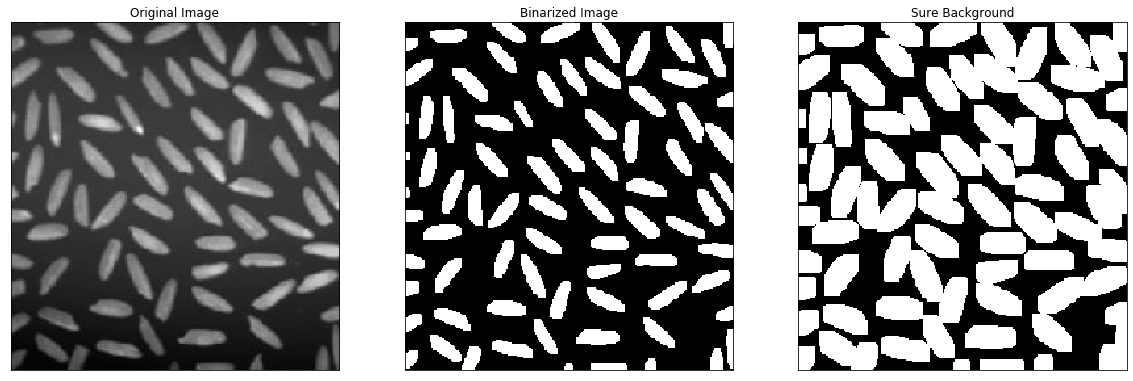

In [25]:
# Find sure background area
img_sure_bg = cv2.dilate( img_bin, kernel, iterations=3)

tools.multiPlot( 1, 3, ( img, img_bin, img_sure_bg),
                ( 'Original Image', 'Binarized Image', 'Sure Background'),
                cmap_tuple=( cm.gray, cm.gray, cm.gray))


### Find sure foreground

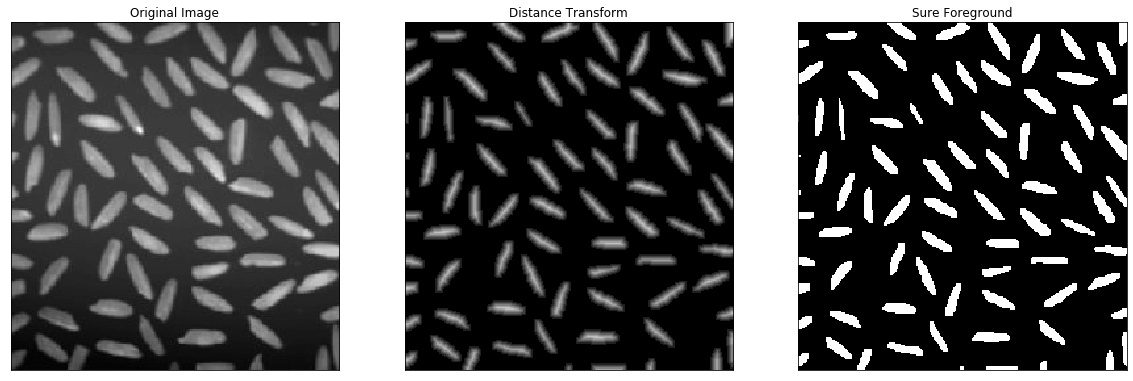

In [26]:
# Find sure foreground area
img_dist_transform = 255 * normalize_image( cv2.distanceTransform( img_bin, cv2.DIST_L2, 5))
otsu_threshold, img_sure_fg = cv2.threshold( img_dist_transform.astype(np.uint8), 0,255,cv2.THRESH_BINARY + cv2.THRESH_OTSU)
ret, img_sure_fg = cv2.threshold( img_dist_transform.astype(np.uint8), 1.5 * otsu_threshold, 255,cv2.THRESH_BINARY)

tools.multiPlot( 1, 3, ( img, img_dist_transform, img_sure_fg),
                ( 'Original Image', 'Distance Transform', 'Sure Foreground'),
                cmap_tuple=( cm.gray, cm.gray, cm.gray))

### Find unknown region

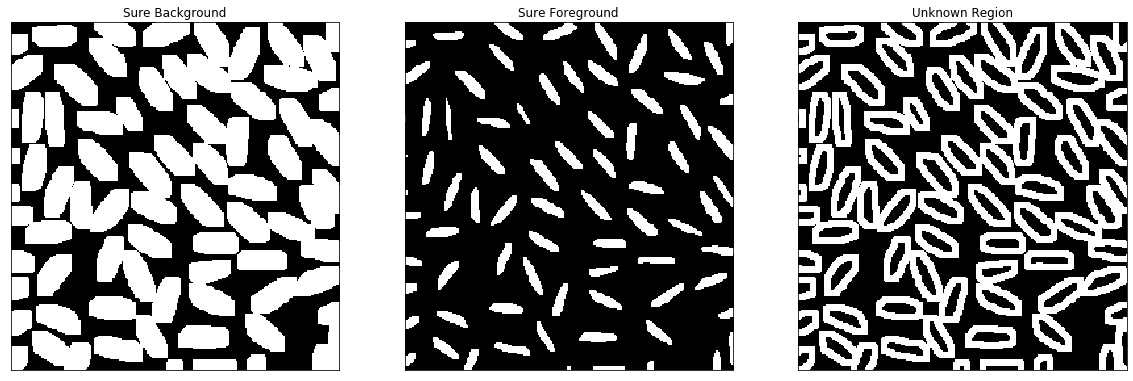

In [27]:
# Finding unknown region
img_sure_fg = np.uint8( img_sure_fg)
img_unknown = cv2.subtract( img_sure_bg, img_sure_fg)

tools.multiPlot( 1,3, ( img_sure_bg, img_sure_fg, img_unknown),
                ( 'Sure Background', 'Sure Foreground', 'Unknown Region'),
                cmap_tuple=( cm.gray, cm.gray, cm.gray))

### Sure labeling of image

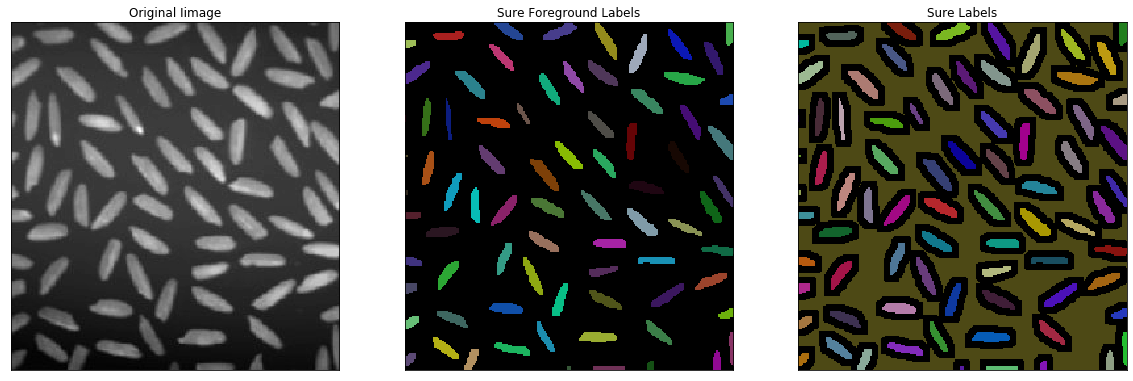

In [28]:
# Sure foreground labelling
ret, img_sure_fg_labels = cv2.connectedComponents( img_sure_fg)

# Add one to all labels so that sure background is not 0, but 1 ...
img_sure_labels = img_sure_fg_labels + 1

# ... and, mark the region of unknown label with zero
img_sure_labels[img_unknown==255] = 0

# Plot the images
num_fg_blobs = img_sure_fg_labels.max( )
labelFgColors = tools.getRandomColorMap( num_fg_blobs+1, bg_color=0)

num_blobs = img_sure_labels.max( )
labelColors = tools.getRandomColorMap( num_blobs + 1, bg_color=0)

tools.multiPlot( 1,3, ( img, img_sure_fg_labels, img_sure_labels),
                ( 'Original Iimage', 'Sure Foreground Labels', 'Sure Labels'),
                cmap_tuple=( cm.gray, labelFgColors, labelColors))


### Final segmentation

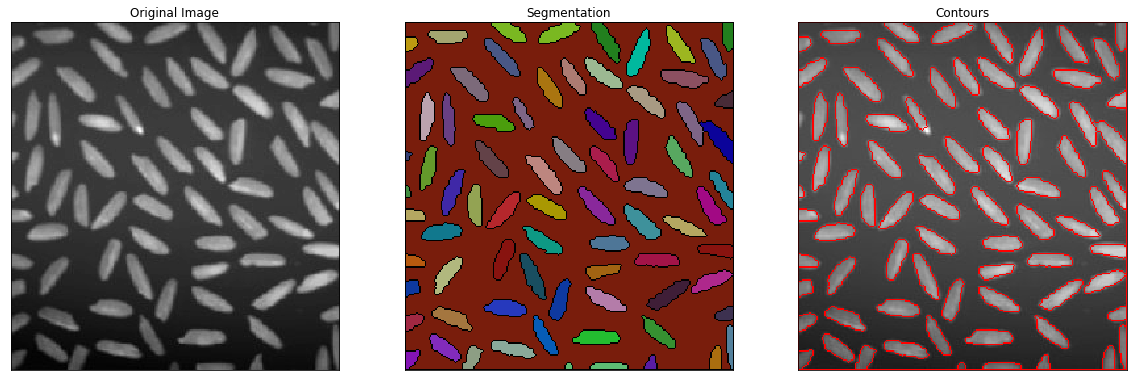

In [29]:
img_rgb = cv2.cvtColor( img, cv2.COLOR_GRAY2RGB)
img_labels = cv2.watershed( img_rgb, img_sure_labels)

img_rgb[img_labels == -1] = [255,0,0]

tools.multiPlot( 1,3, ( img, img_labels, img_rgb),
                ( 'Original Image', 'Segmentation', 'Contours'),
                cmap_tuple=( cm.gray, labelColors, None))

